In [1]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
from langchain_core.messages import BaseMessage,HumanMessage
from langchain_cerebras import ChatCerebras
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langgraph.prebuilt import tool_node,ToolNode,tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
import requests
import random


In [2]:
load_dotenv()

True

In [3]:
llm=ChatCerebras(model='qwen-3-32b')

In [4]:
#tools
search_tool=DuckDuckGoSearchRun(region='us-en')

@tool
def calculator(first_num:float,second_num:float,operation:str)->dict:
    """perform a basic arithmetic operation on two numbers
       supported operations add,sub,mul,div
    """
    try:
        if operation=="add":
            result=first_num+second_num
        elif operation=="sub":
            result=first_num-second_num
        elif operation=="mul":
            result=first_num*second_num
        elif operation=="div":
            if second_num==0:
                return {"error":'division by zero is not allowed '}
            result =first_num/second_num   
        else:
            return {"error":f"Unsupported operation{operation}"}
        return {"first_num":first_num,"second_num":second_num,"operation":operation,"result":result}   
    except Exception as e:
        return {'error':str(e)}


@tool
def get_stock_price(symbol:str)->dict:
    """fetch latest stock price for  a given symbol(e.g.'AAPL','TSLA')
    using alpha vantage with api key in the url"""
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=K44XDH1PL3FUE3V4"
    r = requests.get(url)
    return r.json()
    

In [5]:
tools=[search_tool,get_stock_price,calculator]
llm_with_tools=llm.bind_tools(tools)


In [6]:
class ChatState(TypedDict):
    messages:Annotated[list[BaseMessage],add_messages]
    

In [7]:
def chat_node(state:ChatState):
    """LLM node that may answer or request a tool call """
    messages=state['messages']
    response=llm_with_tools.invoke(messages)
    return {"messages":[response]}

tool_node=ToolNode(tools)
    

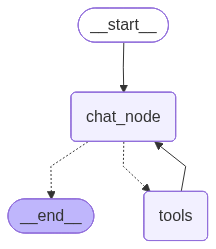

In [9]:
graph=StateGraph(ChatState)
graph.add_node("chat_node",chat_node)
graph.add_node("tools",tool_node)
graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition)
graph.add_edge('tools','chat_node')
graph.compile()